In [252]:
import os, json, time, re
import random, collections, cPickle
import numpy as np
import pandas as pd
%matplotlib inline  

In [88]:
data_path = '/Users/matt.meng/Downloads'
file_name = 'small_articles.json'

In [91]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
def process_raw_data(data_path, file_name):
    start_time = time.time()
    with open(os.path.join(data_path, file_name), 'r') as input:
        counter = 0
        title_df = pd.DataFrame(columns=['title', 'pageView'])
        for line in input:
            json_doc = json.loads(line)
            #publisher_id = json_doc['pv_publisherId']
            expected_keys = ['pv_title', 'pv_url', 'pv_pageViews']
            if not all([key in json_doc.keys() for key in expected_keys]):
                continue
            title, url, pageView = json_doc['pv_title'], json_doc['pv_url'], json_doc['pv_pageViews']
            if not isEnglish(title):
                continue
            title_df.loc[url] = pd.Series({'title' : title, 'pageView' : pageView})
    title_df.index.name = 'url'
    print 'finished processing all the data using {:.2f} seconds'.format(time.time() - start_time) 
    return title_df

In [92]:
title_df = process_raw_data(data_path, file_name)

finished processing all the data using 123.05 seconds


In [93]:
print title_df.shape
title_df.head()

(20913, 2)


,title,pageView
url,,
http://www.nydailynews.com/news/national/transgender-navy-seal-slams-trump-banning-servicemembers-article-1.3358836,Transgender Navy SEAL slams Trump for banning ...,410271
http://www.nydailynews.com/new-york/delta-pilot-flight-attendant-fight-delays-takeoff-laguardia-article-1.3352751,"Delta pilot, flight attendant fight delays tak...",234898
http://www.nydailynews.com/news/national/fbi-suspect-custody-cruise-ship-death-article-1.3361442,FBI has suspect in custody in cruise ship death,151344
http://www.nydailynews.com/life-style/u-s-navy-aircraft-carrier-sets-sail-no-urinals-article-1.3352063,New U.S. Navy aircraft carrier sets sail with ...,24271
https://www.cbssports.com/mlb/news/seven-bold-predictions-for-the-2017-mlb-trade-deadline/,Seven bold predictions for the 2017 MLB trade ...,100887


In [94]:
title_df.to_csv('/Users/matt.meng/Downloads/title_data.csv', index=True, encoding='utf-8')

In [241]:
file_name = '/Users/matt.meng/Downloads/title_data.csv'

In [242]:
data = pd.read_csv(file_name, index_col='url', encoding='utf-8')

In [243]:
print data.shape
data.head()

(20913, 2)


,title,pageView
url,,
http://www.nydailynews.com/news/national/transgender-navy-seal-slams-trump-banning-servicemembers-article-1.3358836,Transgender Navy SEAL slams Trump for banning ...,410271
http://www.nydailynews.com/new-york/delta-pilot-flight-attendant-fight-delays-takeoff-laguardia-article-1.3352751,"Delta pilot, flight attendant fight delays tak...",234898
http://www.nydailynews.com/news/national/fbi-suspect-custody-cruise-ship-death-article-1.3361442,FBI has suspect in custody in cruise ship death,151344
http://www.nydailynews.com/life-style/u-s-navy-aircraft-carrier-sets-sail-no-urinals-article-1.3352063,New U.S. Navy aircraft carrier sets sail with ...,24271
https://www.cbssports.com/mlb/news/seven-bold-predictions-for-the-2017-mlb-trade-deadline/,Seven bold predictions for the 2017 MLB trade ...,100887


In [244]:
def basic_tokenizer(line, normalize_digits=True):
    line = line.replace("'s", '')
    line = re.sub("\.", '', line)
    line = re.sub('[!"#%\'()*+,/:;<=>?@\[\]^_{|}~`’”“′‘\\\]', ' ', line)
    line = re.sub('[\n\t ]+', ' ', line)
    words = []
    #_WORD_SPLIT = re.compile(b"([.,!?\"'-<>:;)(])")
    _DIGIT_RE = re.compile(r"\d")
    for token in line.strip().lower().split():
        if not token:
            continue
        if normalize_digits:
            token = re.sub(_DIGIT_RE, b'#', token)
        words.append(token)
    return len(words), ' '.join(words)

In [279]:
'''
# way to check the tokenizer
index = random.randint(0, data.shape[0])
print index
print data['title'][index]
print basic_tokenizer(data['title'][index])
'''

"\n# way to check the tokenizer\nindex = random.randint(0, data.shape[0])\nprint index\nprint data['title'][index]\nprint basic_tokenizer(data['title'][index])\n"

In [277]:
# tokenize the titles
data['title_word_counts'], data['processed_title'] = zip(*data['title'].map(basic_tokenizer))
# sort by the title word counts and filter them
sorted_data = data.sort_values(by=['title_word_counts', 'pageView'], ascending=[True, False])
index = (sorted_data['title_word_counts'] >= 4) & (sorted_data['title_word_counts'] <= 15)
filtered_data = sorted_data.loc[index, :]

In [280]:
filtered_data.head()

,title,pageView,title_word_counts,processed_title
url,,,,
http://www.nydailynews.com/opinion/football-brink-article-1.3355753,Football on the brink,15339,4,football on the brink
http://www.chicagotribune.com/news/opinion/huppke/ct-trump-sessions-ohio-boy-scout-huppke-20170726-story.html,Donald Trump's abnormal behavior,5651,4,donald trump abnormal behavior
http://www.nydailynews.com/opinion/sacred-article-1.3359322,Every one is sacred,2095,4,every one is sacred
http://www.nydailynews.com/opinion/immigration-reform-mission-article-1.3355621,Immigration reform: Mission possible,1749,4,immigration reform mission possible
http://www.nydailynews.com/opinion/ugly-american-president-article-1.3288340,The ugly American President,515,4,the ugly american president


#### build the vocabulary dictionary

In [281]:
'''
def create_vocab_dict(data, column_name, freq_threshold=2):
    vocab_dict = {}
    titles = []
    for title in data[column_name]:
        words = []
        for token in basic_tokenizer(title):
            words.append(token)
            if token not in vocab_dict:
                vocab_dict[token] = 0
            vocab_dict[token] += 1
        titles.append(words)
    print 'total {} tokens are ideintified...'.format(len(vocab_dict))
    sorted_pairs = sorted(vocab_dict.items(), key=lambda x : x[1], reverse=True)

    offset = 4
    UKN_index = offset - 1
    token_dict, reverse_token_dict = {}, {UKN_index : 'UKN'}
    unique_counts = 0
    for i, pair in enumerate(sorted_pairs):
        if pair[1] >= freq_threshold:
            unique_counts += 1
            token_dict[pair[0]] = i + offset
            reverse_token_dict[(i + offset)] = pair[0]
        else:
            token_dict[pair[0]] = UKN_index
    print 'total {} unique tokens are included in the token dictionary...'.format(unique_counts)            
    for i in xrange(len(titles)):
          titles[i] = map(token_dict.get, titles[i])
    return token_dict, reverse_token_dict, titles
'''

def create_vocab_dict(data, column_name, freq_threshold=2):
    vocab_dict = {}
    titles = []
    for title in data[column_name]:
        words = []
        for token in title.split(' '):
            words.append(token)
            if token not in vocab_dict:
                vocab_dict[token] = 0
            vocab_dict[token] += 1
        titles.append(words)
    print 'total {} tokens are ideintified...'.format(len(vocab_dict))
    sorted_pairs = sorted(vocab_dict.items(), key=lambda x : x[1], reverse=True)

    offset = 4
    UKN_index = offset - 1
    token_dict, reverse_token_dict = {}, {UKN_index : 'UKN'}
    unique_counts = 0
    for i, pair in enumerate(sorted_pairs):
        if pair[1] >= freq_threshold:
            unique_counts += 1
            token_dict[pair[0]] = i + offset
            reverse_token_dict[(i + offset)] = pair[0]
        else:
            token_dict[pair[0]] = UKN_index
    print 'total {} unique tokens are included in the token dictionary...'.format(unique_counts)            
    for i in xrange(len(titles)):
          titles[i] = map(token_dict.get, titles[i])
    return token_dict, reverse_token_dict, titles

In [282]:
token_dict, reverse_token_dict, titles = create_vocab_dict(filtered_data, 'processed_title')

total 22767 tokens are ideintified...
total 12575 unique tokens are included in the token dictionary...


In [286]:
print filtered_data.shape, len(titles)
pickle_file = 'content.pkl'

url_list = filtered_data.index.tolist()
content = {'url' : url_list, 
           'titles' : titles, 
           'token_dict' : token_dict,
           'reverse_token_dict' : reverse_token_dict}

with open(pickle_file, 'wb') as handle:
    cPickle.dump(content, handle, protocol=cPickle.HIGHEST_PROTOCOL)

(20244, 4) 20244


In [288]:
import cPickle as pickle

class DataGenerator(object):

    def __init__ (self, pickle_file_path):
        self._cur_index = 0
        with open(pickle_file_path, 'rb') as input_stream:
            self.data = pickle.load(input_stream)
        self.titles = self.data['titles']
        self.reverse_token_dict = self.data['reverse_token_dict']
        self.data_size = len(self.titles)
    
    def generate_sequence(self, batch_size):
        
        while True:
            if self._cur_index + batch_size <= self.data_size:
                start_index = self._cur_index
                self._cur_index += batch_size
                yield self.titles[start_index : self._cur_index]
            else:
                start_index = self._cur_index
                self._cur_index = self._cur_index + batch_size - self.data_size
                yield self.titles[start_index : self.data_size].extend(self.titles[0 : self._cur_index])        

In [289]:
dataGen = DataGenerator(pickle_file)

In [302]:
dataGen.reverse_token_dict[3]

'UKN'

In [292]:
seq = dataGen.generate_sequence(20)

In [309]:
next(seq)

[[3, 3, 4208, 9322, 1073],
 [529, 6984, 6880, 318, 739],
 [3, 4153, 1790, 6, 3],
 [2457, 96, 16, 2298, 3468],
 [3609, 7438, 3, 3, 4772],
 [3, 3, 433, 5, 140],
 [348, 2220, 3, 21, 352],
 [139, 1935, 303, 5, 6924],
 [12024, 3, 8297, 3, 3],
 [292, 430, 172, 7944, 93],
 [1676, 4445, 946, 192, 12],
 [92, 280, 3211, 164, 1508],
 [12322, 2133, 2841, 2384, 6857],
 [3219, 5, 9, 1579, 3],
 [8006, 3, 1073, 3, 3],
 [781, 8915, 1477, 4978, 1426],
 [2911, 3, 316, 7, 3],
 [6974, 8239, 495, 1420, 7317],
 [2541, 2732, 1490, 569, 2015],
 [2703, 2509, 19, 3784, 3355]]

In [257]:
sorted_data.loc[sorted_data['title_word_counts'] >= 5]

,title,pageView,title_word_counts,processed_title
url,,,,
http://www.nydailynews.com/opinion/new-life-east-midtown-article-1.3343073,New life for East Midtown,13,5,new life for east midtown
http://www.nydailynews.com/opinion/bring-next-gen-urban-farming-article-1.3359066,Bring on next-gen urban farming,224,5,bring on next-gen urban farming
http://www.chicagotribune.com/news/opinion/editorials/ct-cmap-region-planning-2050-edit-0703-md-20170630-story.html,Planning for a new Chicagoland,3,5,planning for a new chicagoland
"http://www.chicagotribune.com/business/ct-illinois-home-sales-0725-biz-20170724-story,amp.html",Chicago-area home sales lose momentum,28,5,chicago-area home sales lose momentum
"http://www.chicagotribune.com/news/local/breaking/ct-southwest-side-drive-by-victim-identified-20170712-story,amp.html",Southwest Side drive-by victim identified,1,5,southwest side drive-by victim identified
http://www.nydailynews.com/new-york/fire-union-furious-deutsche-fire-verdict-demands-investigation-article-1.158002,Fire union demands Deutsche probe,1,5,fire union demands deutsche probe
http://www.nydailynews.com/life-style/co-op-board-no-pet-rule-killed-wife-dispute-therapy-dog-widower-lawsuit-article-1.999062,No-pet rule killed my wife,1,5,no-pet rule killed my wife
http://www.greenvilleonline.com/story/life/style/talk-greenville/2017/06/30/minutes-holly-julian/103319768/,15 Minutes with Holly Julian,13,5,## minutes with holly julian
http://www.chicagotribune.com/sports/rosenblog/ct-jose-quintana-jon-lester-number-2-pitcher-rosenbloom-20170714-column.html,The Jose Quintana-Jon Lester connection,3,5,the jose quintana-jon lester connection


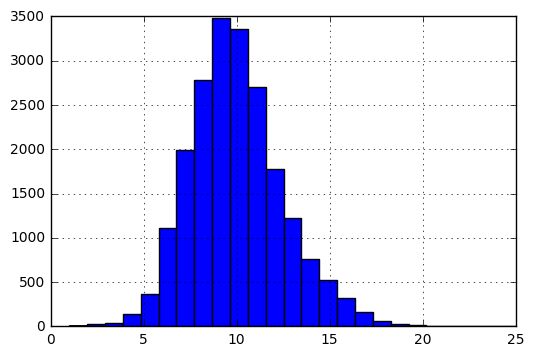

In [255]:
sorted_data['title_word_counts'].hist(bins=25)

#### the unique vocabulary counts

In [219]:
counter = collections.Counter(vocab_dict.values())

total 23176 tokens are ideintified...
total 12821 unique tokens are included in the token dictionary...


(20913, 2) 20913


In [196]:
sorted_pairs = sorted(vocab_dict.items(), key=lambda x : x[1], reverse=True)


#### frequency counts

In [186]:
counter

Counter({1: 10355,
         2: 3827,
         3: 1919,
         4: 1272,
         5: 810,
         6: 593,
         7: 467,
         8: 359,
         9: 302,
         10: 291,
         11: 225,
         12: 186,
         13: 140,
         14: 142,
         15: 134,
         16: 120,
         17: 91,
         18: 100,
         19: 88,
         20: 94,
         21: 66,
         22: 73,
         23: 73,
         24: 63,
         25: 57,
         26: 55,
         27: 59,
         28: 41,
         29: 41,
         30: 33,
         31: 32,
         32: 40,
         33: 37,
         34: 34,
         35: 28,
         36: 26,
         37: 20,
         38: 23,
         39: 25,
         40: 20,
         41: 29,
         42: 21,
         43: 17,
         44: 15,
         45: 21,
         46: 19,
         47: 15,
         48: 22,
         49: 13,
         50: 13,
         51: 15,
         52: 20,
         53: 10,
         54: 11,
         55: 14,
         56: 12,
         57: 13,
         58: 16,
 

In [182]:
sum(vocab_dict.values()) * 0.05

10307.45

In [178]:
sorted_pairs[10000]

(u'canular', 2)

In [ ]:
for key in vocab_dict.keys:

19218
Kiss rockers Gene Simmons, Paul Stanley to open rock 'n' roll-themed restaurants in Chicagoland
[u'kiss', u'rockers', u'gene', u'simmons', u'paul', u'stanley', u'to', u'open', u'rock', u'n', u'roll-themed', u'restaurants', u'in', u'chicagoland']


In [154]:
data['title'][10]

u'Prominent NYC Judge Died by Suicide in Drowning, Medical Examiner Rules'

In [54]:
basic_tokenizer(data['title'][10])

[u'one',
 u'dead',
 u'and',
 u'five',
 u'injured',
 u'after',
 u'malfunction',
 u'at',
 u'ohio',
 u'state',
 u'fair']

In [127]:
index = random.randint(0, data.shape[0])
print index
print data['title'][index]
print basic_tokenizer(data['title'][index])

11146
Amtrak CEO on Smooth Start to 'Summer of Hell': Commuters Have 'Figured It Out'

[]


In [65]:
index = 17218
print type(data['title'][index])

<type 'unicode'>


In [69]:
print type(data['title'][40])
print data['title'][40]

<type 'unicode'>
MLB Trade Deadline: The details of Rangers' Yu Darvish's 10-team no-trade list


In [71]:
data['title'][40].encode(encoding='utf-8').decode('ascii')

u"MLB Trade Deadline: The details of Rangers' Yu Darvish's 10-team no-trade list"